In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Storytelling
L'obbiettivo di questa analisi è mostrare/vedere l'impatto dei cartellini rossi e gialli sul risultato delle partite e sul market value dei giocatori

In [3]:
# Load data from CSV files
games = pd.read_csv('./data/games.csv')
game_events = pd.read_csv('./data/game_events.csv')
players = pd.read_csv('./data/players.csv')
competitions = pd.read_csv('./data/competitions.csv')
appearances = pd.read_csv('./data/appearances.csv')

card_events = game_events[game_events['type'] == 'Cards']
goal_events = game_events[game_events['type'] == 'Goals']

In [5]:
# la colonna description contiene una grande quantità di valori null. Siccome la utilizzeremo per distinguere i cartellini rossi e gialli, dobbiamo gestire il problema
# Gestire i valori nulli nella colonna 'description'
game_events['description'] = game_events['description'].fillna('')

# Filtrare i cartellini gialli e rossi
num_yellow = game_events[(game_events['type'] == 'Cards') & (game_events['description'].str.contains('yellow', case=False))]
num_red = game_events[(game_events['type'] == 'Cards') & (game_events['description'].str.contains('red', case=False) | game_events['description'].str.contains('second', case=False))]
num_tot = game_events[game_events['type'] == 'Cards']

print(
    f' Numero cartellini rossi: {len(num_red)}\n',
    f'Numero cartellini gialli: {len(num_yellow)}\n',
    f'Numero cartellini totali: {len(num_tot)}'
)

game_events['description'] = game_events['description'].fillna('yellow')


 Numero cartellini rossi: 3585
 Numero cartellini gialli: 60693
 Numero cartellini totali: 62473


Vediamo che la stragrande maggioranza dei cartellini sono cartellini gialli <br>
perciò sostiuiremo i valori vuoti con cartellini gialli

## Data Cleaning:

### Creazione tabella 
Per comodità creiamo un nuovo file che contenga le informazioni che ci interessano per fare le nostre considerazioni:
il numero di cartellini ricevuti, il numero di goal fatti e ricevuti e il risultato della partita

In [ ]:
not_nan = game_events.copy()

# Funzione per contare i cartellini in base al tipo specificato
def count_cards(game_id, club_id, card_type=None):
    events = not_nan[(not_nan['game_id'] == game_id) & (not_nan['club_id'] == club_id)]
    if card_type is None:
        return len(events[events['type'] == 'Cards'])
    elif card_type == 'yellow':
        return len(events[
            (events['type'] == 'Cards') &
            (events['description'].str.contains('yellow', case=False)) &
            (~events['description'].str.contains('second', case=False))
        ])
    elif card_type == 'red':
        return len(events[
            (events['type'] == 'Cards') &
            (events['description'].str.contains('red', case=False) | 
             events['description'].str.contains('second', case=False))
        ])

# Creiamo il nuovo dataframe che contenga i dati sopra citati
transformed_games = []

# Creiamo una nuova tabella con le colonne qui sotto indicate per togliere la divisione tra home e away club
for index, row in games.iterrows():
    home_row = {
        'game_id': row['game_id'],
        'club_id': row['home_club_id'],
        'date': row['date'],
        'competition_id': row['competition_id'],
        'season': row['season'],
        'round': row['round'],
        'goals_received': row['away_club_goals'],
        'goals_made': row['home_club_goals'],
        'cards_received': count_cards(row['game_id'], row['home_club_id']),
        'cards_received_yellow': count_cards(row['game_id'], row['home_club_id'], 'yellow'),
        'cards_received_red': count_cards(row['game_id'], row['home_club_id'], 'red'),
        'is_win': 1 if row['home_club_goals'] > row['away_club_goals'] else (
            0 if row['home_club_goals'] < row['away_club_goals'] else -1)
    }

    away_row = {
        'game_id': row['game_id'],
        'club_id': row['away_club_id'],
        'date': row['date'],
        'competition_id': row['competition_id'],
        'season': row['season'],
        'round': row['round'],
        'goals_received': row['home_club_goals'],
        'goals_made': row['away_club_goals'],
        'cards_received': count_cards(row['game_id'], row['away_club_id']),
        'cards_received_yellow': count_cards(row['game_id'], row['away_club_id'], 'yellow'),
        'cards_received_red': count_cards(row['game_id'], row['away_club_id'], 'red'),
        'is_win': 1 if row['away_club_goals'] > row['home_club_goals'] else (
            0 if row['away_club_goals'] < row['home_club_goals'] else -1)
    }

    transformed_games.append(home_row)
    transformed_games.append(away_row)

# Convertiamo la struttura in un dataframe di panda
transformed_games_df = pd.DataFrame(transformed_games)

# Salviamo il DataFrame nel CSV
transformed_games_df.to_csv('./data/transformed_games.csv', index=False)


### 1) Distribuzione dei valori di cards_received:

In [12]:
# importiamo il csv appena creato
games_df = pd.read_csv('./data/transformed_games.csv')

In [8]:
# Intanto vediamo qual è la distribuzione del numero di cartellini 
print(
    f' Massimo e minimo tra i valori di cards_received: \n {games_df['cards_received'].min()} {games_df['cards_received'].max()}')

# Vediamo che il massimo è 11 cartellini, che essendo veramente tanti sarebbe meglio controllare il numero di record per ciascun valore 
(games_df['cards_received']).value_counts().sort_index()

# Vediamo che il numero di record con un valore di numero cartellini compreso tra 5 e 11 è davvero basso. Ciò potrebbe portare a risultati fallati. 
# Potrebbe essere una buona idea raggruppare i valori maggiori di 4 in un unica etichetta '5+'
games_df['cards_received'] = games_df['cards_received'].apply(lambda x: 5 if x >= 5 else x)
(games_df['cards_received']).value_counts().sort_index()



 Massimo e minimo tra i valori di cards_received: 
 0 5


cards_received
0    105375
1      6872
2      7440
3      5522
4      3070
5      2153
Name: count, dtype: int64

# Analisi:

 ## differenza di probabilità di sconfitta in base al numero di cartellini ricevuti <br>
 Per poter visualizzare questa eventualità utilizzeremo una heatmap per mettere in relazione la probabilità di sconfitta con il numero di cartellini ricevuti

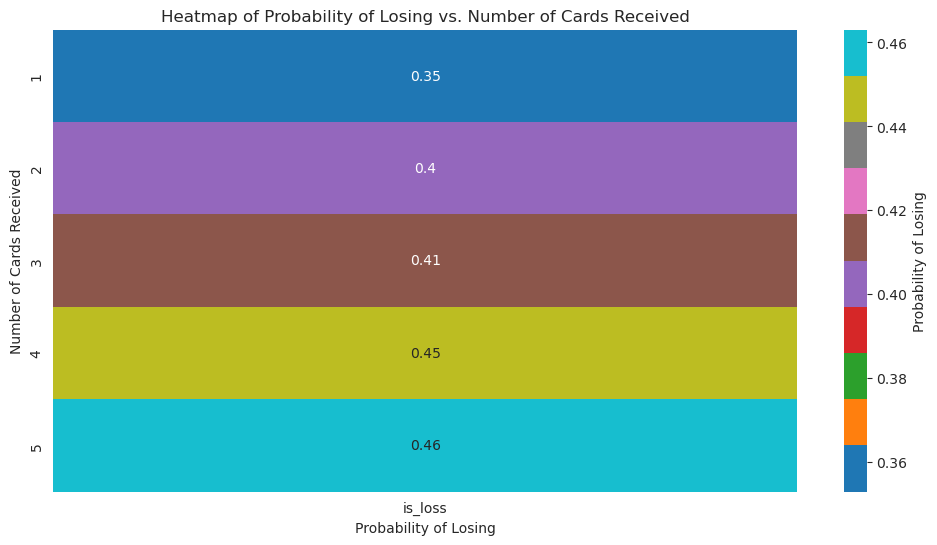

In [9]:
# Filtrare le partite con numero di cartellini maggiore di 0
games_with_cards = (games_df[games_df['cards_received'] > 0]).copy()

games_with_cards.loc[:, 'is_loss'] = games_with_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0)  # per semplicità aggiungiamo una colonna is_loss

# contiene come index il numero di cartellini e come valore la probabilità di sconfitta
pivot_table = games_with_cards.pivot_table(values='is_loss', index='cards_received', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.color_palette("hls", 8)
sns.heatmap(pivot_table, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'})
plt.title('Heatmap of Probability of Losing vs. Number of Cards Received')
plt.xlabel('Probability of Losing')
plt.ylabel('Number of Cards Received')
plt.show()


Sembra effettivamente che la probabilità di sconfitta aumenti all'aumentare dell'numero di cartellini

## 2) Probabilità di sconfitta in base al numero di cartellini gialli e rossi

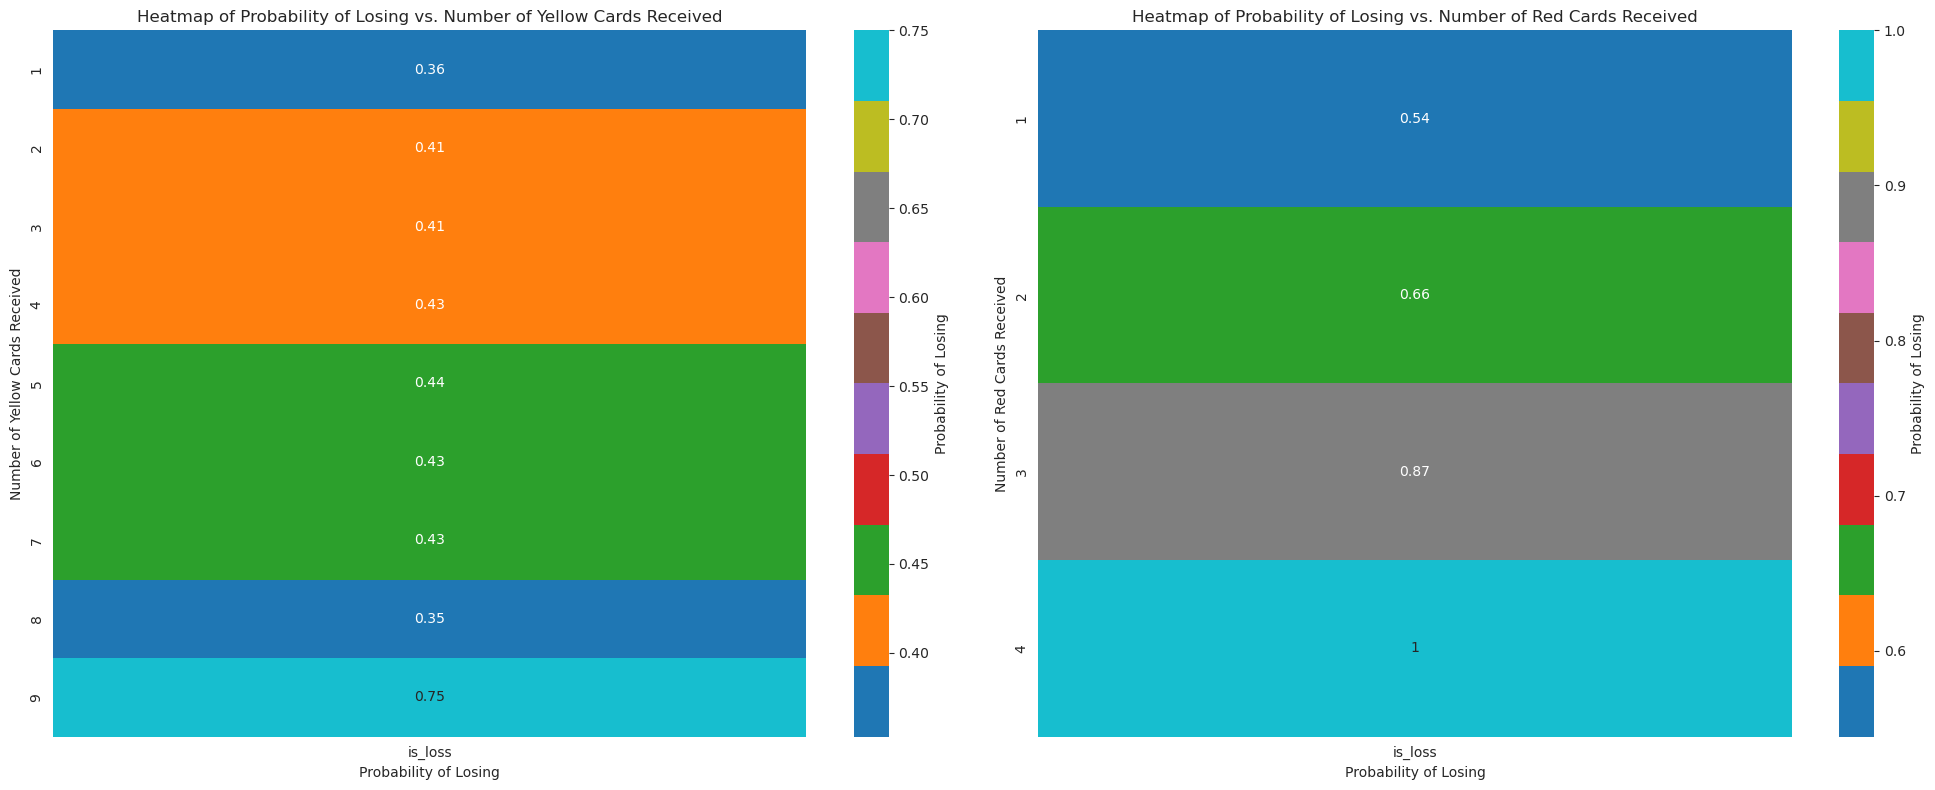

In [30]:
# Filtriamo le partite in cui il numero di cartellini è > 0
games_with_yellow_cards = (games_df[games_df['cards_received_yellow'] > 0]).copy()
games_with_red_cards = (games_df[games_df['cards_received_red'] > 0]).copy()

# Aggiungiamo una colonna per comodità per indicare la sconfitta 
games_with_yellow_cards.loc[:, 'is_loss'] = games_with_yellow_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0) 

games_with_red_cards.loc[:, 'is_loss'] = games_with_red_cards['is_win'].apply(
    lambda x: 1 if x == 0 else 0)  

# Creiamo una nuova tabella contenente come indice il numero di cartellini presi e come valore il numero medio di sconfitte
pivot_table_yellow = games_with_yellow_cards.pivot_table(values='is_loss', index='cards_received_yellow', aggfunc='mean')
pivot_table_red = games_with_red_cards.pivot_table(values='is_loss', index='cards_received_red', aggfunc='mean')

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap per cartellini gialli
sns.heatmap(pivot_table_yellow, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'}, ax=ax[0])
ax[0].set_title('Heatmap of Probability of Losing vs. Number of Yellow Cards Received')
ax[0].set_xlabel('Probability of Losing')
ax[0].set_ylabel('Number of Yellow Cards Received')

# Heatmap per cartellini rossi
sns.heatmap(pivot_table_red, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'}, ax=ax[1])
ax[1].set_title('Heatmap of Probability of Losing vs. Number of Red Cards Received')
ax[1].set_xlabel('Probability of Losing')
ax[1].set_ylabel('Number of Red Cards Received')

plt.tight_layout()
plt.show()


Vediamo che anche in questo caso al crescere del numero di cartellini gialli o rossi la probabilità di sconfitta sale di conseguenza.

## Correlazione tra il minutaggio dei goal e il minutaggio dei cartellini
vediamo quanto spesso un goal è segnato in una finestra di tempo vicino al minuto in cui viene ricevuto un cartellino

In [12]:
# Definire una finestra temporale per considerare i goal vicino al minuto del cartellino
time_window = 6  # finestra temporale in minuti

card_events = card_events.rename(columns={'minute': 'minute_card'})
goal_events = goal_events.rename(columns={'minute': 'minute_goal'})

merged_events = pd.merge_asof(card_events.sort_values('minute_card'), 
                              goal_events.sort_values('minute_goal'), 
                              left_on='minute_card', 
                              right_on='minute_goal', 
                              by='game_id', 
                              tolerance=time_window, 
                              direction='nearest')


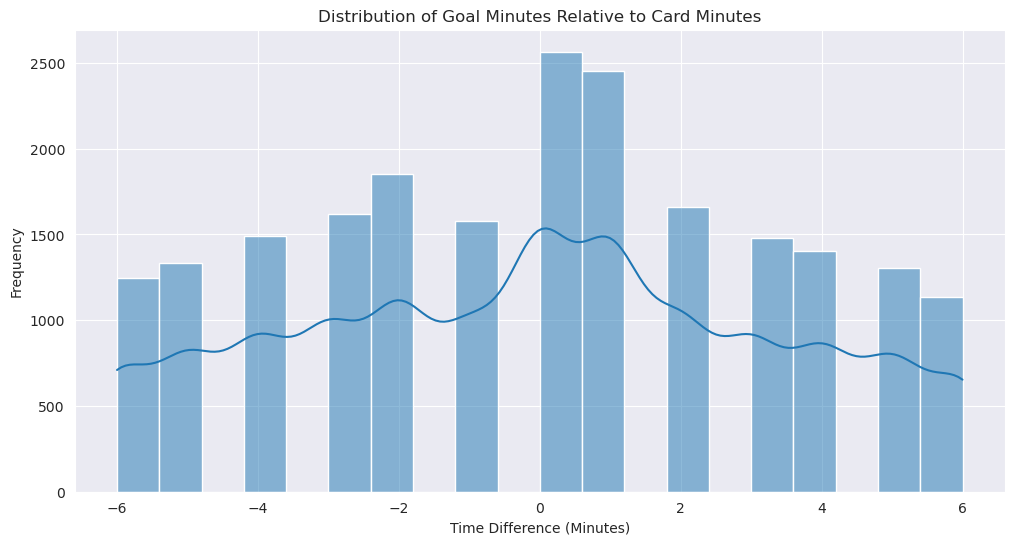

In [13]:
merged_events['time_difference'] = merged_events['minute_goal'] - merged_events['minute_card']

plt.figure(figsize=(12, 6))
sns.histplot(merged_events['time_difference'], bins=20, kde=True)
plt.title('Distribution of Goal Minutes Relative to Card Minutes')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Frequency')
plt.show()


Vediamo come dopo lo zero c'è effettivamente un'aumento del numero di goal ricevuti

In [14]:
# Separare i goal che avvengono prima e dopo i cartellini
goals_before_cards = merged_events[merged_events['time_difference'] < 0]
goals_after_cards = merged_events[merged_events['time_difference'] > 0]

# Conteggio dei goal precedenti e successivi
num_goals_before = len(goals_before_cards)
num_goals_after = len(goals_after_cards)

print(f'Numero di goal precedenti ad un cartellino: {num_goals_before}')
print(f'Number of goals successivi ad un cartellino: {num_goals_after} \n')

# Percentuale di goal precedenti e successivi
perc_goals_before = num_goals_before / len(merged_events) * 100
perc_goals_after = num_goals_after / len(merged_events) * 100

print(f'Percentuale di goal precedenti ad un cartellino: {perc_goals_before:.2f}%')
print(f'Percentuale di goal successivi ad un cartellino: {perc_goals_after:.2f}%')


Numero di goal precedenti ad un cartellino: 9115
Number of goals successivi ad un cartellino: 9438 

Percentuale di goal precedenti ad un cartellino: 14.59%
Percentuale di goal successivi ad un cartellino: 15.11%


### Vediamo che una parte consistente dei goal è fatta poco tempo dopo l'assegnamento di un cartellino, il che fa pensare che ci sia una correlazione tra i due eventi

## Vediamo se il numero di cartellino impatta sul market value dei singoli giocatori

Vediamo subito se c'è una correlazione tra il marketvalue dei giocatori e il numero di cartellini presi

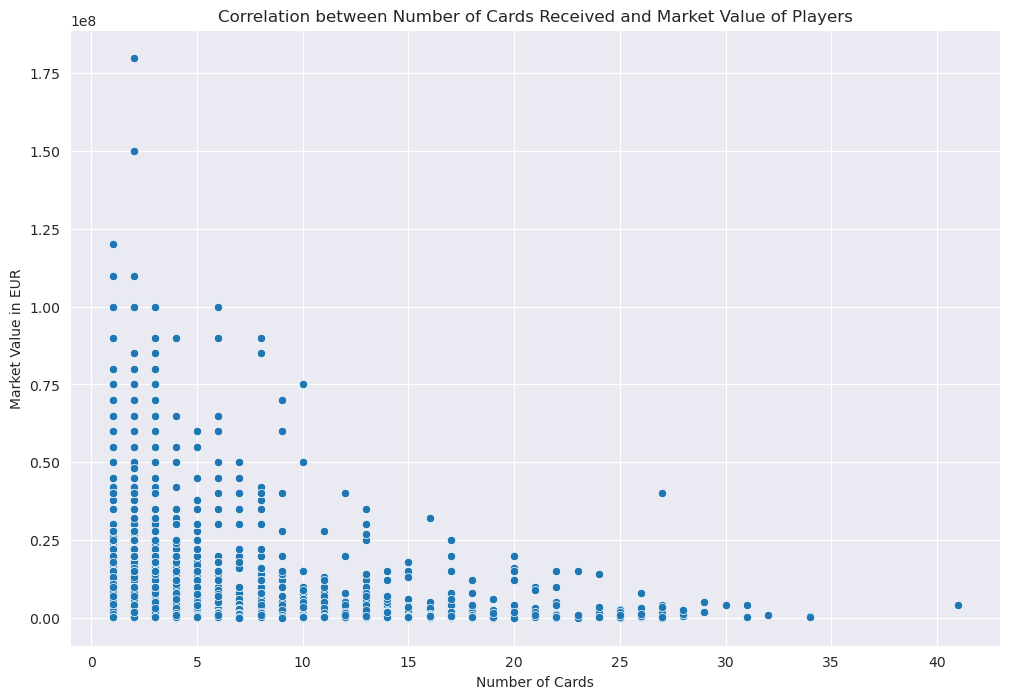

In [19]:
# Calcolare il numero totale di cartellini per giocatore
player_cards_count = card_events.groupby('player_id').size().reset_index(name='number_of_cards')

# Unire i dati dei giocatori con i dati dei cartellini
player_market_value = players[['player_id', 'market_value_in_eur']].merge(player_cards_count, on='player_id')

# Rimuovere i valori nulli (giocatori senza valore di mercato)
player_market_value = player_market_value.dropna(subset=['market_value_in_eur'])

# Visualizzare la correlazione con un grafico scatter
plt.figure(figsize=(12, 8))
sns.scatterplot(x='number_of_cards', y='market_value_in_eur', data=player_market_value)
plt.title('Correlation between Number of Cards Received and Market Value of Players')
plt.xlabel('Number of Cards')
plt.ylabel('Market Value in EUR')
plt.show() 

#### Vediamo subito che quando un giocatore compie meno falli e quindi prende meno cartellini di media il valore è più alto. Infatti i valori più alti sull'asse delle y si concentrano dove il numero di cartellini è ~ 0
#### Cerchiamo di approfondire il problema facendo la stessa analisi su campionati specifici.

In [13]:
# Calcolare il numero totale di cartellini ricevuti per competizione
total_cards_per_competition = games_df.groupby('competition_id')['cards_received'].sum().reset_index()

# Calcolare il numero totale di partite per competizione
total_games_per_competition = games_df.groupby('competition_id')['game_id'].nunique().reset_index()

# Unire i due dataframes
cards_per_game_per_competition = pd.merge(total_cards_per_competition, total_games_per_competition, on='competition_id')

# Calcolare i cartellini per partita
cards_per_game_per_competition['cards_per_game'] = cards_per_game_per_competition['cards_received'] / cards_per_game_per_competition['game_id']

# Unire con il dataframe delle competizioni per ottenere i nomi delle competizioni
cards_per_game_per_competition = cards_per_game_per_competition.merge(competitions[['competition_id', 'competition_code']], on='competition_id')

# Ordinare i risultati per numero di cartellini per partita
cards_per_game_per_competition = cards_per_game_per_competition.sort_values(by='cards_per_game', ascending=False)

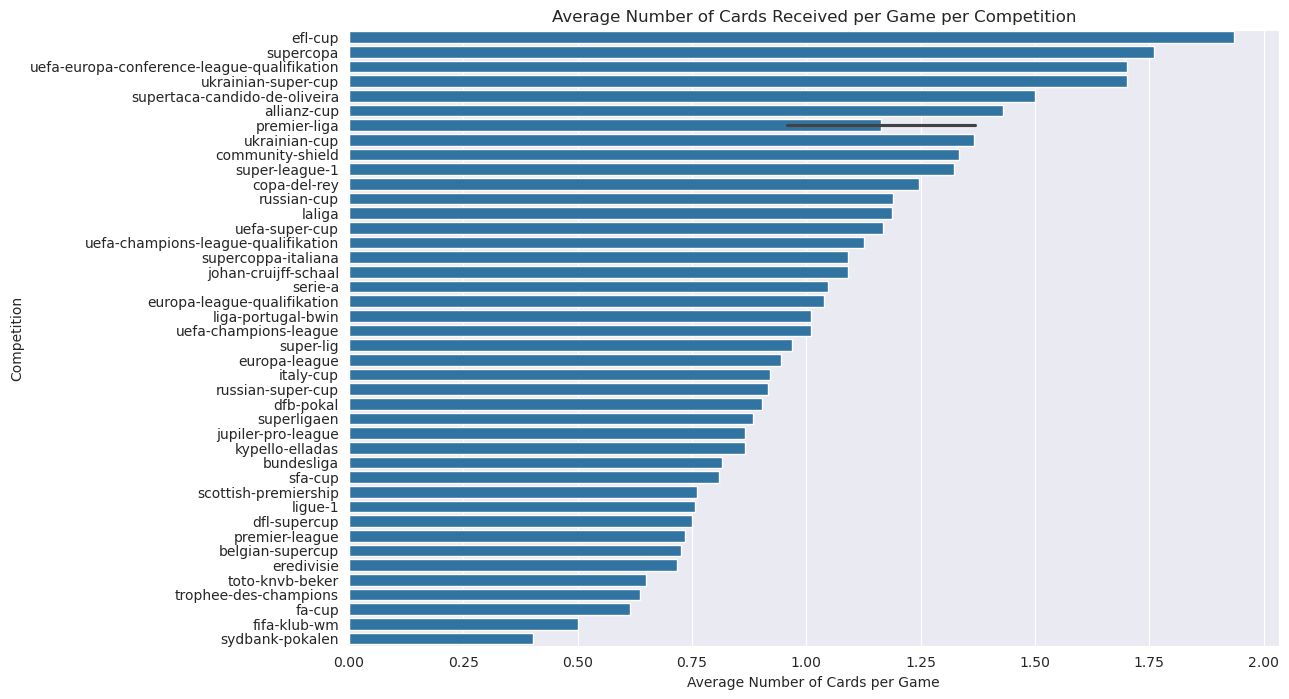

In [16]:
# Grafico a barre per visualizzare il numero di cartellini per partita per competizione
plt.figure(figsize=(12, 8))
sns.barplot(x='cards_per_game', y='competition_code', data=cards_per_game_per_competition)
plt.title('Average Number of Cards Received per Game per Competition')
plt.xlabel('Average Number of Cards per Game')
plt.ylabel('Competition')
plt.show()

### Prendiamo due campionati: 
- #### il primo con un rate di numero di cartellini alto: elf-cup
- #### il secondo con un rate nella media: serie-a
#### Vediamo se facendo la stessa analisi otteniamo dei risultati diversi

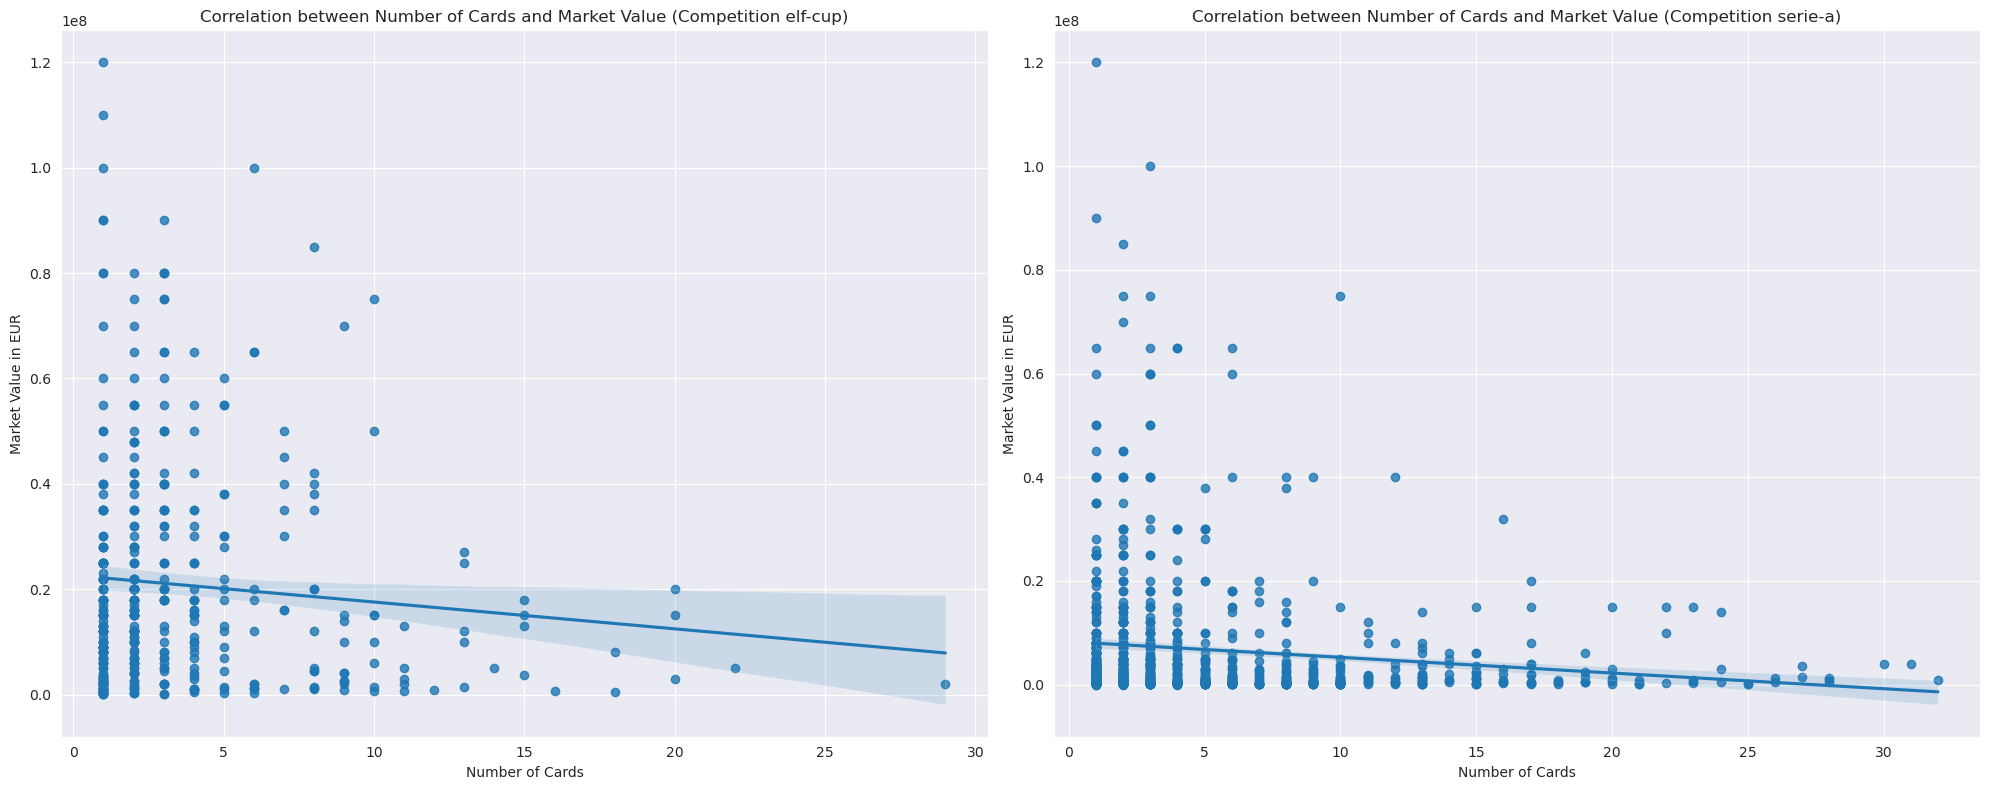

In [20]:
# Calcolare il numero totale di cartellini per giocatore per competizione
player_cards_count = game_events[game_events['type'] == 'Cards'].groupby('player_id').size().reset_index(name='number_of_cards')

# Unire i dati dei giocatori con i dati delle apparizioni per ottenere il competition_id
player_competition = appearances[['player_id', 'competition_id']].drop_duplicates()

# Unire i dati dei giocatori con i dati dei cartellini
player_cards = player_cards_count.merge(player_competition, on='player_id')

# Unire con i dati dei giocatori per ottenere il valore di mercato
player_market_value = player_cards.merge(players[['player_id', 'market_value_in_eur']], on='player_id')

# Filtrare i dati per competizione
player_market_value_cgb = player_market_value[player_market_value['competition_id'] == 'CGB'].dropna(subset=['market_value_in_eur'])
player_market_value_it1 = player_market_value[player_market_value['competition_id'] == 'IT1'].dropna(subset=['market_value_in_eur'])

# Visualizzare la correlazione con grafici scatter e aggiungere la linea di regressione
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Scatterplot per competizione CGB
sns.regplot(x='number_of_cards', y='market_value_in_eur', data=player_market_value_cgb, ax=axs[0])
axs[0].set_title('Correlation between Number of Cards and Market Value (Competition elf-cup)')
axs[0].set_xlabel('Number of Cards')
axs[0].set_ylabel('Market Value in EUR')

# Scatterplot per competizione IT1
sns.regplot(x='number_of_cards', y='market_value_in_eur', data=player_market_value_it1, ax=axs[1])
axs[1].set_title('Correlation between Number of Cards and Market Value (Competition serie-a)')
axs[1].set_xlabel('Number of Cards')
axs[1].set_ylabel('Market Value in EUR')

plt.tight_layout()
plt.show()

#### Vediamo che effettivamente c'è una differenza tra questi due campionati:
Seppur rimane bassa la correlazione vediamo che in un campionato dove il rate di cartellini è basso (serie-a) viene premiato meno un giocatore che compie meno falli. Vediamo che infatti la linea che mostra il trend del grafico, anche se è una pendenza negativa, è poco ripida. Ciò mostra che un giocatore che compie tanti falli e uno che compie pochi falli in media il loro valore di mercato non differisce di molto. <br>
Invece in un campionato dove la media di cartellini è molto alta (elf-cup) è ragionevole pensare che un giocatore che è anche in grado di non compiere un alto numero di falli venga premiato molto. Infatti vediamo che la linea che rappresenta il trend nel primo grafico è molto più pendente.

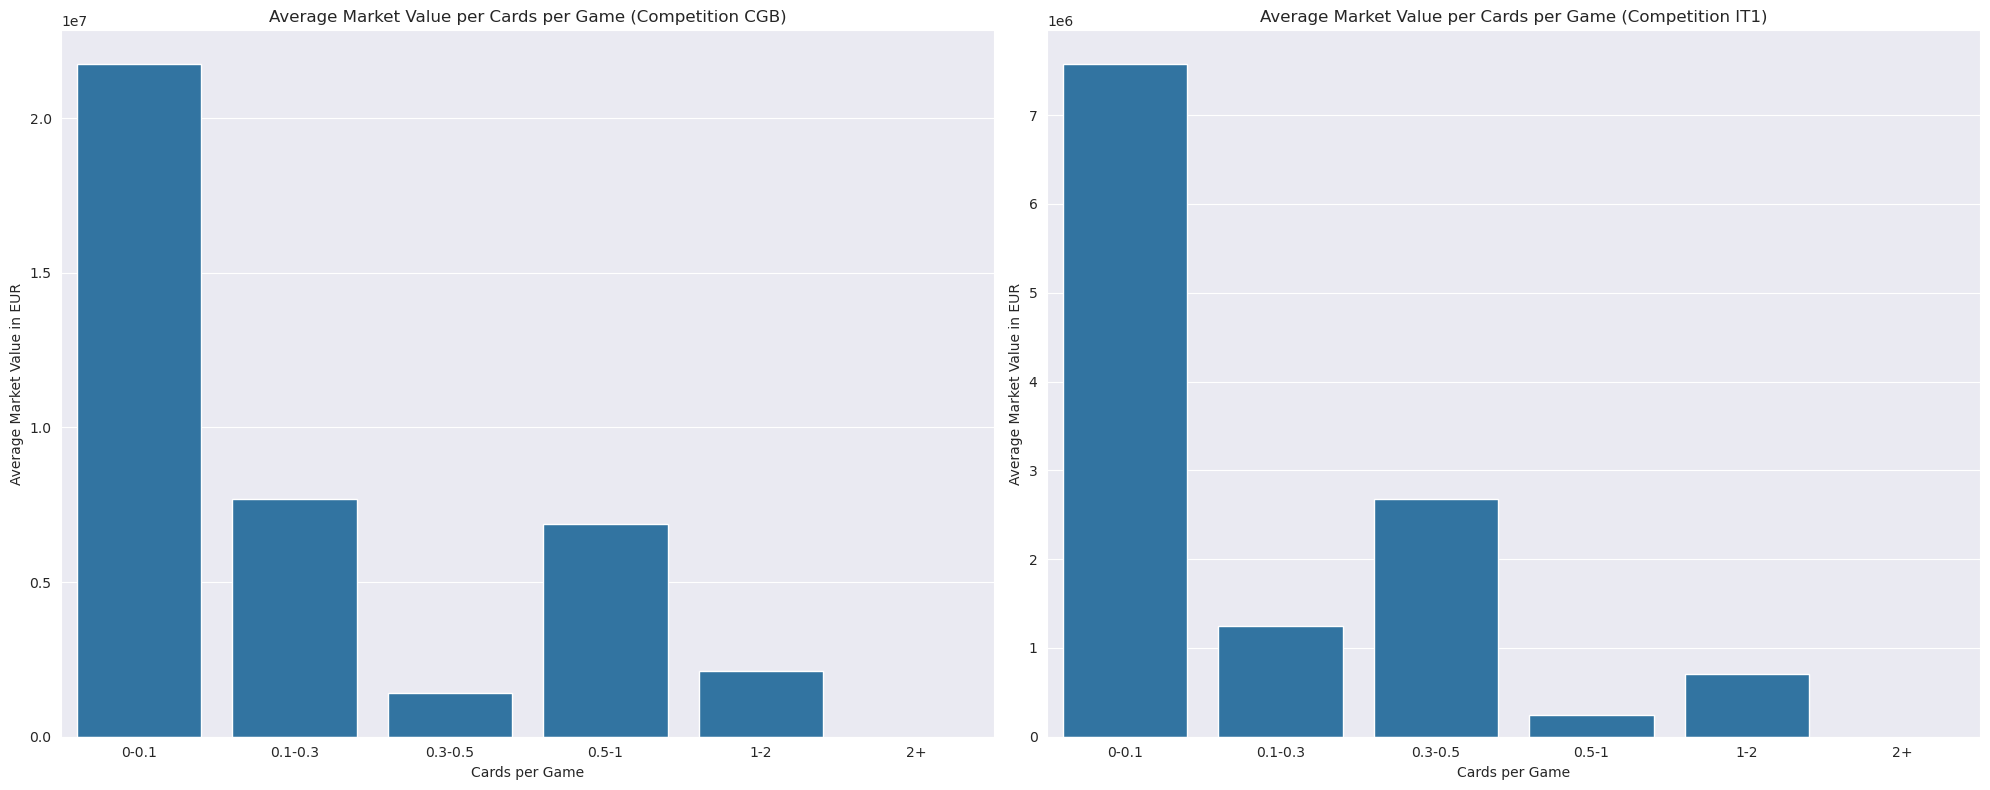

In [29]:
# Calcolare il numero totale di cartellini per giocatore
player_cards_count = game_events[game_events['type'] == 'Cards'].groupby('player_id').size().reset_index(name='number_of_cards')

# Calcolare il numero di partite giocate per ciascun giocatore
player_games_count = appearances.groupby('player_id').size().reset_index(name='number_of_games')

# Unire i dati dei giocatori con i dati delle apparizioni per ottenere il competition_id
player_competition = appearances[['player_id', 'competition_id']].drop_duplicates()

# Unire i dati dei giocatori con i dati dei cartellini e delle partite giocate
player_stats = player_cards_count.merge(player_games_count, on='player_id').merge(player_competition, on='player_id')

# Calcolare il numero medio di cartellini per partita
player_stats['cards_per_game'] = player_stats['number_of_cards'] / player_stats['number_of_games']

# Unire con i dati dei giocatori per ottenere il valore di mercato
player_market_value = player_stats.merge(players[['player_id', 'market_value_in_eur']], on='player_id')

# Rimuovere i valori nulli (giocatori senza valore di mercato)
player_market_value = player_market_value.dropna(subset=['market_value_in_eur'])

# Creare fasce per il numero medio di cartellini per partita
bins = [0, 0.1, 0.3, 0.5, 1, 2, 5]  # Puoi regolare questi valori in base ai tuoi dati
labels = ['0-0.1', '0.1-0.3', '0.3-0.5', '0.5-1', '1-2', '2+']
player_market_value['cards_per_game_bins'] = pd.cut(player_market_value['cards_per_game'], bins=bins, labels=labels, right=False)

# Filtrare i dati per competizione
player_market_value_cgb = player_market_value[player_market_value['competition_id'] == 'CGB']
player_market_value_it1 = player_market_value[player_market_value['competition_id'] == 'IT1']

# Calcolare il valore di mercato medio per ogni fascia di numero medio di cartellini per partita per ciascuna competizione
market_value_mean_cgb = player_market_value_cgb.groupby('cards_per_game_bins', observed=True)['market_value_in_eur'].mean().reset_index()
market_value_mean_it1 = player_market_value_it1.groupby('cards_per_game_bins', observed=True)['market_value_in_eur'].mean().reset_index()

# Visualizzare i risultati con due grafici a barre
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Grafico a barre per competizione CGB
sns.barplot(x='cards_per_game_bins', y='market_value_in_eur', data=market_value_mean_cgb, ax=axs[0])
axs[0].set_title('Average Market Value per Cards per Game (Competition CGB)')
axs[0].set_xlabel('Cards per Game')
axs[0].set_ylabel('Average Market Value in EUR')

# Grafico a barre per competizione IT1
sns.barplot(x='cards_per_game_bins', y='market_value_in_eur', data=market_value_mean_it1, ax=axs[1])
axs[1].set_title('Average Market Value per Cards per Game (Competition IT1)')
axs[1].set_xlabel('Cards per Game')
axs[1].set_ylabel('Average Market Value in EUR')

plt.tight_layout()
plt.show()

#### Mostriamo infine il valore di mercato medio differenziato per le due competizioni di prima in base. Viene messo in relazione il numero medio di cartellini e il valore di mercato medio tra le varie stagioni. Si vede chiaramente che per entrambe le competizioni comunque una media di cartellini bassa corrisponde ad un market value più alto
